In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Dense, Embedding, Flatten, Input, Multiply, StringLookup
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/recommender/recommendation_historical_data 2.csv',usecols=['reseller_id','sku'])

## Data Preprocessing

In [ ]:
data = data.dropna()
data.head()

In [ ]:
data_users = data['reseller_id']
data_items = data['sku']

In [ ]:
train_users, test_users, train_items, test_items = train_test_split(data_users, data_items,
                                                                    test_size=0.01, random_state=42, shuffle=True)
train_data = pd.DataFrame((zip(train_users, train_items)),columns=['reseller_id', 'sku'])

In [ ]:
train_data.head()

We do have a problem now though. We see that every sample in the dataset now belongs to the positive class. However we also require negative samples to train our models, to indicate products that the user has not interacted with. We assume that such products are those that the user are not interested in - even though this is a sweeping assumption that may not be true, it usually works out rather well in practice.

The code below generates 4 negative samples for each row of data. In other words, the ratio of negative to positive
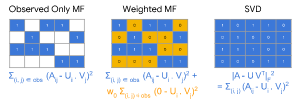

In [ ]:
# Get a list of all sku_ids
all_sku_ids = train_data['sku'].unique()
all_reseller_ids = train_data['reseller_id'].unique()
# Placeholders that will hold the training data
reseller_id, sku, interactions = [], [], []
# This is the set of items that each user has interaction with
reseller_sku_set = set(zip(train_data['reseller_id'], train_data['sku']))
# 4:1 ratio of negative to positive samples
num_negatives = 4
for (u, i) in tqdm(reseller_sku_set):
    reseller_id.append(u)
    sku.append(i)
    interactions.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_sku_ids)
        # check that the user has not interacted with this item
        while (u, negative_item) in reseller_sku_set:
            negative_item = np.random.choice(all_sku_ids)
        reseller_id.append(u)
        sku.append(negative_item)
        interactions.append(0) # items not interacted with are negative

  0%|          | 0/262180 [00:00<?, ?it/s]

In [ ]:
binarize_data = pd.DataFrame(list(zip(reseller_id, sku, interactions)),columns=['reseller_id', 'sku', 'interactions'])
binarize_data.head()

putting 89% of the data in the training set, 10% in the validation set, and 1% in the test set

In [ ]:
data_x = np.array(binarize_data[['reseller_id', 'sku']].values)
data_y = np.array(binarize_data[['interactions']].values)
# split validation data
train_data_x, val_data_x, train_data_y, val_data_y = train_test_split(data_x, data_y, test_size=0.1, random_state=42, shuffle=True)
print("Train Data Shape {}".format(train_data_x.shape))
print("Validation Data Shape {}".format(val_data_x.shape))

Train Data Shape (1179810, 2)
Validation Data Shape (131090, 2)


In [ ]:
# train data
train_data_users = train_data_x[:,0]
train_data_items = train_data_x[:,1]
# validation data
val_data_users = val_data_x[:,0]
val_data_items = val_data_x[:,1]

## Model Development

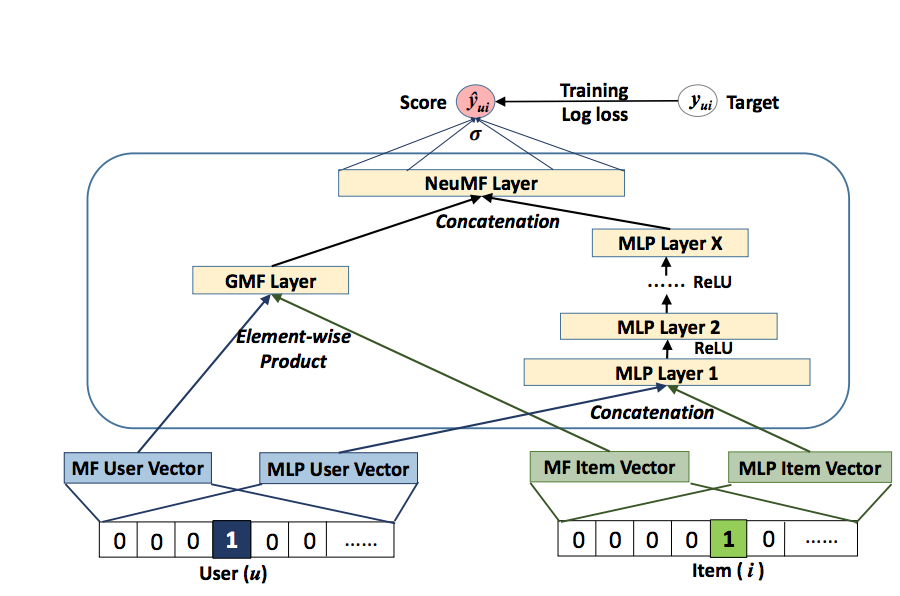

In [ ]:
number_of_users = data['reseller_id'].nunique()
number_of_items = data['sku'].nunique()
latent_dim_mf = 4
latent_dim_mlp = 32
reg_mf = 0
reg_mlp = 0.01
dense_layers = [8, 4]
reg_layers = [0.01, 0.01]
activation_dense = "relu"

In [ ]:
user_input = Input(shape=(), dtype="string", name="reseller_id")
item_input = Input(shape=(), dtype="string", name="sku")


# A preprocessing layer which maps string features to integer indices.
# Keras provides tf.keras.layers.StringLookup to handle encoding and decoding for us
user_string_lookup = StringLookup(vocabulary=all_reseller_ids, mask_token=None)
item_string_lookup = StringLookup(vocabulary=all_sku_ids, mask_token=None)

#Embedding layers
mf_user_embeddings = Sequential([
    user_string_lookup,
    Embedding(input_dim=number_of_users+1, output_dim=latent_dim_mf,
                               name="mf_user_embedding", embeddings_initializer="RandomNormal",
                               embeddings_regularizer=l2(reg_mf))
])


mf_item_embeddings = Sequential([
    item_string_lookup,
    Embedding(input_dim=number_of_items+1, output_dim=latent_dim_mf,
                               name="mf_item_embedding", embeddings_initializer="RandomNormal",
                               embeddings_regularizer=l2(reg_mf))
])


mlp_user_embeddings = Sequential([
    user_string_lookup,
    Embedding(input_dim=number_of_users+1, output_dim=latent_dim_mlp,
                               name="mlp_user_embedding", embeddings_initializer="RandomNormal",
                               embeddings_regularizer=l2(reg_mlp))
])

mlp_item_embeddings = Sequential([
    item_string_lookup,
    Embedding(input_dim=number_of_items+1, output_dim=latent_dim_mlp,
                               name="mlp_item_embedding", embeddings_initializer="RandomNormal",
                               embeddings_regularizer=l2(reg_mlp))
])


# MF vector
mf_user_latent = Flatten()(mf_user_embeddings(user_input))
mf_item_latent = Flatten()(mf_item_embeddings(item_input))
GMF_layer = Multiply()([mf_user_latent, mf_item_latent])


# MLP vector
mlp_user_latent = Flatten()(mlp_user_embeddings(user_input))
mlp_item_latent = Flatten()(mlp_item_embeddings(item_input))
mlp_cat_latent = Concatenate()([mlp_user_latent, mlp_item_latent])

mlp_vector = mlp_cat_latent

# build dense layers for model
for i in range(len(dense_layers)):
  layer = Dense(
  dense_layers[i],
  activity_regularizer=l2(reg_layers[i]),
  activation=activation_dense,
  name="layer%d" % i)
  mlp_vector = layer(mlp_vector)

NeuMf_layer = Concatenate()([GMF_layer, mlp_vector])

result = Dense(1, activation="sigmoid", kernel_initializer="lecun_uniform", name="interaction")
output = result(NeuMf_layer)

model = Model(inputs=[user_input, item_input], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 reseller_id (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 sku (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 32)           458528      ['reseller_id[0][0]']            
                                                                                                  
 sequential_3 (Sequential)      (None, 32)           121664      ['sku[0][0]']                    
                                                                                              

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

## Model Training & Evaluation

In [ ]:
history = model.fit(x=[train_data_users, train_data_items], y=train_data_y,
                      batch_size=32, epochs=5,
                      validation_data=([val_data_users, val_data_items], val_data_y))


Epoch 1/5
36870/36870 [==============================] - 809s 22ms/step - loss: 0.3925 - accuracy: 0.8534 - precision: 0.7238 - recall: 0.4310 - auc: 0.8566 - val_loss: 0.3207 - val_accuracy: 0.8699 - val_precision: 0.7378 - val_recall: 0.5463 - val_auc: 0.8926
Epoch 2/5
36870/36870 [==============================] - 802s 22ms/step - loss: 0.3000 - accuracy: 0.8784 - precision: 0.7588 - recall: 0.5743 - auc: 0.9056 - val_loss: 0.2936 - val_accuracy: 0.8781 - val_precision: 0.7505 - val_recall: 0.5883 - val_auc: 0.9051
Epoch 3/5
36870/36870 [==============================] - 807s 22ms/step - loss: 0.2777 - accuracy: 0.8842 - precision: 0.7654 - recall: 0.6067 - auc: 0.9153 - val_loss: 0.2887 - val_accuracy: 0.8800 - val_precision: 0.7508 - val_recall: 0.6016 - val_auc: 0.9088
Epoch 4/5
36870/36870 [==============================] - 850s 23ms/step - loss: 0.2721 - accuracy: 0.8865 - precision: 0.7687 - recall: 0.6183 - auc: 0.9191 - val_loss: 0.2858 - val_accuracy: 0.8810 - val_precision

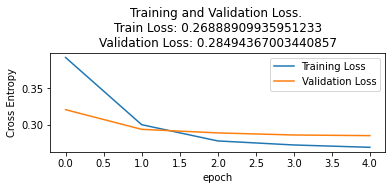

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('model.h5')

## Evaluating our Recommender System
Now that our model is trained, we are ready to evaluate it using the test data. In traditional Machine Learning projects, we evaluate our models using metrics such as Accuracy (for classification problems) and RMSE (for regression problems). However, such metrics are too simplistic for evaluating recommender systems.

To design a good metric for evaluating recommender systems, we need to first understand how modern recommender systems are used.




The key here is that we don't need the user to interact on every single item in the list of recommendations. Instead, we just need the user to interact with at least one item on the list - as long as the user does that, the recommendations have worked.

To simulate this, let's run the following evaluation protocol to generate a list of 10 recommended items for each user.


*   For each user, randomly select 99 items that the user has not interacted with
*   Combine these 99 items with the test item (the actual item that the user interacted with). We now have 100 items.
*   Run the model on these 100 items, and rank them according to their predicted probabilities
*  Select the top 10 items from the list of 100 items. If the test item is present within the top 10 items, then we say that this is a hit.




Repeat the process for all users. The Hit Ratio is then the average hits.
This evaluation protocol is known as Hit Ratio @ 10, and it is commonly used to evaluate recommender systems.

In [ ]:
# (User=>bought item) pairs for testing
test_user_item_set = set(zip(test_users, test_items))

# Dict of all items that are interacted with by each user
user_interacted_items = data.groupby('reseller_id')['sku'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(random.sample(test_user_item_set, int(len(test_user_item_set)*0.5))):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_sku_ids) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model.predict([np.array([u]*len(test_items)), np.array(test_items)]))

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.3f}".format(np.average(hits)))

  0%|          | 0/2673 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step
The Hit Ratio @ 10 is 0.823


#### The Hit Ratio @ 10 is 0.8

In [ ]:
model = tf.keras.models.load_model('/content/model.h5')

In [ ]:
def recommend_items(user,items):
  predicted_labels = np.squeeze(model.predict([np.array([user]*len(items)), np.array(items)]))
  return pd.DataFrame((zip([user]*len(items), items, predicted_labels)),columns=['reseller_id', 'sku', 'score'])



In [ ]:
recommended_df = recommend_items(user="56b3c99d-15b1-4aad-978c-86e5a230ded8",items=data_items.unique())


119/119 [==============================] - 3s 25ms/step


In [ ]:
def recommend_top_items(user,items,k=10):
  predicted_labels = np.squeeze(model.predict([np.array([user]*len(items)), np.array(items)]))
  top_items = [items[i] for i in np.argsort(predicted_labels)[::-1][0:k].tolist()]
  return top_items

In [ ]:
recommend_top_items(user="56b3c99d-15b1-4aad-978c-86e5a230ded8",items=data_items.unique(),k=20)